In [150]:
import pandas as pd
from sklearn.decomposition import PCA
from scapy.all import *
import binascii
import numpy as np


# Laboratorio 5

## Parte 1
#### 1. Capture 10 paquetes con la herramienta scapy, imprima el tipo de datos, la longitud y el contenido del pcap

In [98]:
ipsniff = sniff(count=10)
print("Length =", len(ipsniff))
ipsniff.summary()

Length = 10
Ether / IP / UDP 142.250.217.238:https > 192.168.2.91:59967 / Raw
Ether / IP / UDP 142.250.217.238:https > 192.168.2.91:59967 / Raw
Ether / IP / UDP 142.250.217.238:https > 192.168.2.91:59967 / Raw
Ether / IP / UDP 142.250.217.238:https > 192.168.2.91:59967 / Raw
Ether / IP / UDP 192.168.2.91:59967 > 142.250.217.238:https / Raw
Ether / IP / UDP 142.250.217.238:https > 192.168.2.91:59967 / Raw
Ether / IP / UDP 192.168.2.74:43476 > 255.255.255.255:6667 / Raw
Ether / IP / TCP 34.237.73.95:https > 192.168.2.91:37612 PA / Raw
Ether / IP / TCP 192.168.2.91:37612 > 34.237.73.95:https A
Ether / IP / TCP 192.168.2.91:60336 > 142.250.217.234:https PA / Raw


#### 2. Añada al pcap de 10 paquetes el archivo analisis_paquetes.pcap

In [49]:
packets_pcap = rdpcap("analisis_paquetes.pcap")
print("Length =", len(packets_pcap))
packets_pcap

Length = 62


<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>

In [50]:
packets = ipsniff + packets_pcap
print("Length =", len(packets))
packets

Length = 72


<Sniffed+analisis_paquetes.pcap: TCP:6 UDP:66 ICMP:0 Other:0>

#### 3. Convierta el pcap en un DataFrame

In [53]:
#Codigo tomado de la seccion de archivos Análisis_de_paquetes.ipynb

# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in packets[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos   len     id flags frag ttl proto chksum  ... dataofs  \
0       4   5   0    61  58316    DF    0  64    17  53558  ...    None   
1       4   5   0    61  58317    DF    0  64    17  53557  ...    None   
2       4   5   0    89  18283    DF    0  64    17  28028  ...    None   
3       4   5   0  1030  21360    DF    0  64     6  47029  ...       8   
4       4   5   0   217  21361    DF    0  64     6  47841  ...       8   

  reserved flags window chksum urgptr options payload  \
0     None  None   None  34279   None    None      33   
1     None  None   None  34279   None    None      33   
2     None  None   None  22084   None    None      61   
3        0    PA   3257  12229      0       3     978   
4        0    PA   3257  11416      0       3     165   

                                         payload_raw  \
0  b'\xba.\x01\x00\x00\x01\x00\x00\x00\x00\x00\x0...   
1  b'\xfc)\x01\x00\x00\x01\x00\x00\x00\x00\x00\x0...   
2  b'\xfc)\x81\x80\x00\x01\x00\x01\x00

In [73]:
df.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

#### 4. Muestre los valores de las columnas: Src Address, Dst Address, Src Port y Dst Port

In [56]:
columns = ["src", "dst", "sport", "dport"]
df[columns]

,src,dst,sport,dport
0,192.168.2.91,192.168.2.1,54641,53
1,192.168.2.91,192.168.2.1,54641,53
2,192.168.2.1,192.168.2.91,53,54641
3,192.168.2.91,142.250.217.206,49980,443
4,192.168.2.91,142.250.217.206,49980,443
...,...,...,...,...
67,84.54.22.33,10.1.10.53,53,53
68,10.1.10.53,84.54.22.33,53,53
69,84.54.22.33,10.1.10.53,53,53
70,10.1.10.53,84.54.22.33,53,53


#### 5. Estadísticas
#### a. Muestre cuál es la IP origen más frecuente

In [74]:
df['src'].describe()['top']

'10.1.10.53'

#### b. Muestre cuál es la IP destino más frecuente

In [75]:
df['dst'].describe()['top']

'10.1.10.53'

#### c. ¿A qué IPs se comunica la IP del inciso a?

In [65]:
list(df[df['src'] == "10.1.10.53"]['dst'].unique())

['84.54.22.33', '75.75.75.75']

#### d. ¿A qué puertos destino se comunica la IP del inciso a?

In [71]:
list(df[df['src'] == "10.1.10.53"]['dport'].unique())

[53]

#### e. ¿A qué puertos origen se comunica la IP del inciso b?

In [72]:
list(df[df['dst'] == "10.1.10.53"]['sport'].unique())

[53]

#### f. Indique el propósito de los puertos que más aparece en los incisos d y e

El puerto 53 en UDP se utiliza para transmitir peticiones de DNS

#### 6. Gráficas
#### a. Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

<AxesSubplot: xlabel='Suma payloads', ylabel='IP origen'>

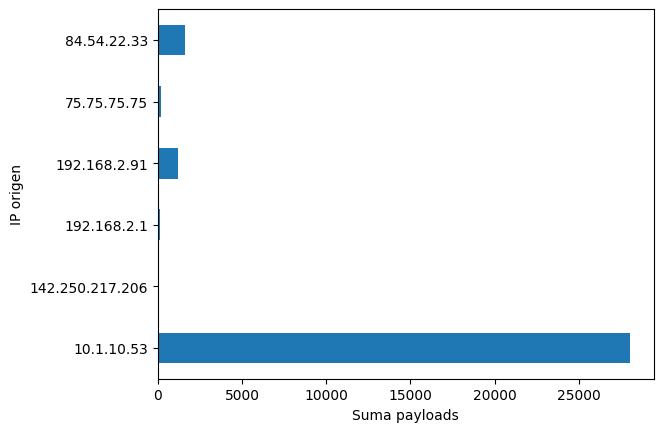

In [91]:
df.groupby('src')["payload"].sum().plot.barh(ylabel="IP origen", xlabel="Suma payloads")

#### b. Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

<AxesSubplot: xlabel='Suma payloads', ylabel='IP destino'>

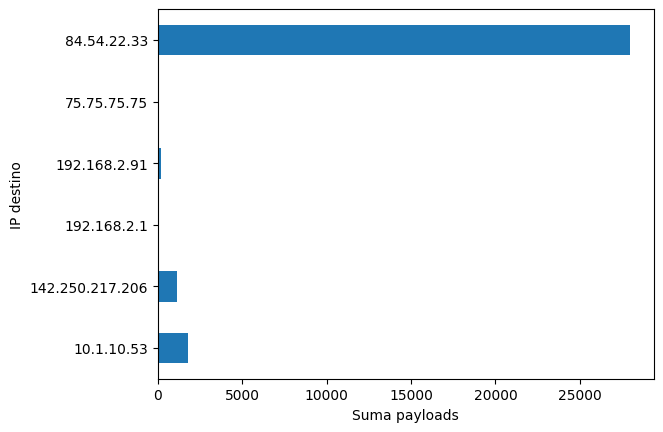

In [92]:
df.groupby('dst')["payload"].sum().plot.barh(ylabel="IP destino", xlabel="Suma payloads")

#### c. Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

<AxesSubplot: xlabel='Suma payloads', ylabel='Puerto origen'>

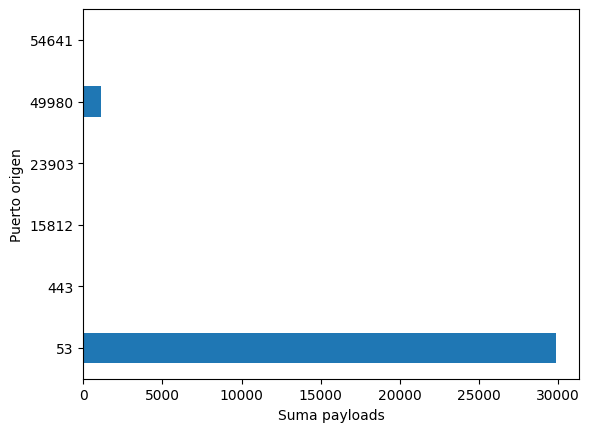

In [93]:
df.groupby('sport')["payload"].sum().plot.barh(ylabel="Puerto origen", xlabel="Suma payloads")

#### d. Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos.

<AxesSubplot: xlabel='Suma payloads', ylabel='Puerto destino'>

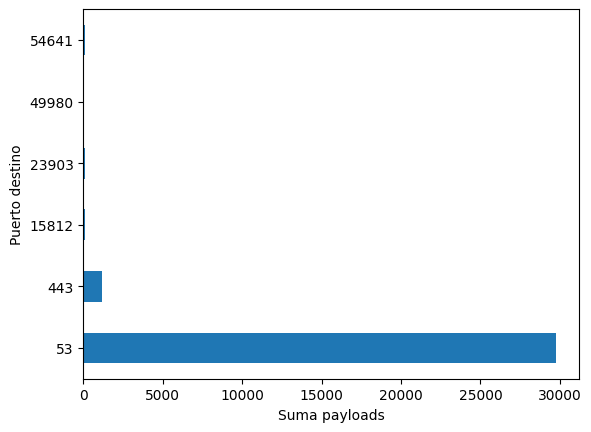

In [95]:
df.groupby('dport')["payload"].sum().plot.barh(ylabel="Puerto destino", xlabel="Suma payloads")

#### 7. Investigación de payload
#### a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen más frecuente.

In [102]:
df_a = df[df['src'] == "10.1.10.53"]
df_a.sample(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
40,4,5,0,1004,1,,0,64,17,21179,...,None,None,None,None,46283,None,None,976,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
33,4,5,0,65,59922,,0,64,17,58829,...,None,None,None,None,20312,None,None,37,b'Q\x19\x01\x00\x00\x01\x00\x00\x00\x00\x00\x0...,b'51190100000100000000000008636c69656e74733406...
68,4,5,0,969,1,,0,64,17,21214,...,None,None,None,None,671,None,None,941,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
52,4,5,0,1010,1,,0,64,17,21173,...,None,None,None,None,45536,None,None,982,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
56,4,5,0,1006,1,,0,64,17,21177,...,None,None,None,None,3200,None,None,978,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


#### b. Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por payload

In [115]:
columns = ['src', 'dst']
df_b = df_a.groupby(columns)[['payload']].sum()
df_b

payload
src        dst                 
10.1.10.53 75.75.75.75       74
           84.54.22.33    27979

#### c. Obtenga la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

In [122]:
df_b[df_b["payload"] == df_b["payload"].max()] # la ip que mas ha intercambiado con la 10.1.10.53 es la 84.54.22.33

,,payload
src,dst,
10.1.10.53,84.54.22.33,27979


#### d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.

In [141]:
ips = ["10.1.10.53", "84.54.22.33"]
df_d =df[df['src'].isin(ips) & df['dst'].isin(ips)]
df_d[['src', 'dst', 'sport', 'dport']]

,src,dst,sport,dport
10,10.1.10.53,84.54.22.33,53,53
11,84.54.22.33,10.1.10.53,53,53
12,10.1.10.53,84.54.22.33,53,53
13,84.54.22.33,10.1.10.53,53,53
14,10.1.10.53,84.54.22.33,53,53
15,84.54.22.33,10.1.10.53,53,53
16,10.1.10.53,84.54.22.33,53,53
17,84.54.22.33,10.1.10.53,53,53
18,10.1.10.53,84.54.22.33,53,53
19,84.54.22.33,10.1.10.53,53,53


#### e. Obtenga los payloads del DF del inciso 6(d?), y añada cada uno en un array.

In [162]:
payloads = [pay for pay in df_d['payload_hex']]
print(len(payloads))

58


#### f. Muestre el contenido del array.

In [168]:
payloads

[b'000c0100000100000000000006676f6f676c6503636f6d00001c0001efbfbd504e470d0a1a0a0000000d4948445200000162000000efbfbd080600000028efbfbd545200003aefbfbd4944415478efbfbdefbfbd097c54efbfbdefbfbdefbfbdefbfbdefbfbd3b4b12083b08efbfbd0a45efbfbdefbfbd2419efbfbdefbfbd5a69dfaa2defbfbd3b4e32efbfbdefbfbd56efbfbd56efbfbd61efbfbd5a1121efbfbdefbfbd01dcbb696b5befbfbd2e6f6befbfbd65efbfbd015cefbfbdefbfbd5defbfbd2defbfbdefbfbdefbfbd64efbfbd08efbfbd08efbfbdefbfbd67efbfbdefbfbdefbfbd3cefbfbdefbfbd4c12efbfbd24337766efbfbdefbfbd023c5f0defbfbd59efbfbd72efbfbdefbfbd79efbfbdefbfbdefbfbd1c0d18efbfbd3863efbfbd65770d1eefbfbdefbfbdefbfbdefbfbd13efbfbd69614befbfbdefbfbdefbfbdefbfbd757dc5b277efbfbd64efbfbdefbfbd15efbfbd2260063a13efbfbd0befbfbd0c16efbfbd12efbfbd26efbfbd39c690efbfbd00efbfbdefbfbdefbfbd081131d28c5148502aefbfbd40044f34efbfbdefbfbdefbfbd373c79efbfbd0e2e39efbfbdefbfbdefbfbd61324061efbfbdefbfbd2622efbfbd1311efbfbd63efbfbd6b4fefbfbd7340efbfbd39efbfbd69efbfbd3458efbfbd78efbfbd4befbfbd612166efbfbdefbfbd3077efbfb

#### g. Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envie a través del puerto explicado en el inciso 5.f?

In [170]:
for item in payloads:
    print(item[:100])

b'000c0100000100000000000006676f6f676c6503636f6d00001c0001efbfbd504e470d0a1a0a0000000d4948445200000162'
b'000c8180000100010000000006676f6f676c6503636f6d00001c0001c00c001c00010000012b00102607f8b0400508070000'
b'000c0100000100000000000006676f6f676c6503636f6d00001c00013aefbfbd6c653ac7a9efbfbdefbfbdefbfbd0cefbfbd'
b'000c8180000100010000000006676f6f676c6503636f6d00001c0001c00c001c00010000012900102607f8b0400508070000'
b'000c0100000100000000000006676f6f676c6503636f6d00001c0001efbfbdefbfbd5e6eefbfbd2727efbfbdefbfbdefbfbd'
b'000c8180000100010000000006676f6f676c6503636f6d00001c0001c00c001c00010000012800102607f8b0400508070000'
b'000c0100000100000000000006676f6f676c6503636f6d00001c0001e48e91426a5fefbfbd610defbfbdefbfbdefbfbd04ef'
b'000c8180000100010000000006676f6f676c6503636f6d00001c0001c00c001c00010000012700102607f8b0400508070000'
b'000c0100000100000000000006676f6f676c6503636f6d00001c0001efbfbdefbfbdefbfbdcbb4efbfbd16efbfbdefbfbd72'
b'000c8180000100010000000006676f6f676c6503636f6d00001c0001c00c00

## Parte 2

In [5]:
df = pd.read_csv("Train_data.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
df_test = pd.read_csv("Test_data.csv")
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [6]:
y = df["class"]
X = df.copy()
X.pop("class")
print(X.shape, y.shape)

(25192, 41) (25192,)


In [8]:
cols = ["protocol_type", "service", "flag"]
X[cols] = X[cols].apply(lambda x: pd.factorize(x)[0] + 1)
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,1,1,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,2,1,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,3,2,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,4,1,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,4,1,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
#Hyperparameters
n_components = 41
whiten = False
random_state = 133

pca = PCA(n_components = n_components, whiten=whiten, random_state=random_state)

In [10]:
x_train_pca = pca.fit_transform(X)


In [12]:
#Varianza original, aun no se ha aplicado la reduccion de dimensionalidad
print("Varianza de los 41 componentes: ", sum(pca.explained_variance_ratio_))

Varianza de los 41 componentes:  1.0
